In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import joblib # Para guardar y cargar modelos
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [4]:
# Cargar el dataset limpio y balanceado
df = pd.read_csv('../data/processed/water_potability_cleaned.csv')
print("Dataset cargado con éxito.")
print("Dimensiones del dataset limpio y balanceado:", df.shape)

Dataset cargado con éxito.
Dimensiones del dataset limpio y balanceado: (3996, 10)


In [5]:
# Separar características (X) y variable objetivo (y)
X = df.drop('Potability', axis=1)
y = df['Potability']

# División en conjunto de entrenamiento (80%) y prueba (20%)
# Usamos stratify=y para mentener la proporción 50/50 que logramos con SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Datos dividios:")
print(f"  -Entrenamiento: {X_train.shape[0]} muestras")
print(f"  -Prueba: {X_test.shape[0]} muestras")

Datos dividios:
  -Entrenamiento: 3196 muestras
  -Prueba: 800 muestras


In [6]:
# Inicializar y ajustar el escalador solo en el set de entrenamiento
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Aplicar la transformación al set de prueba
X_test_scaled = scaler.transform(X_test)

# Guardar el objeto scaler con joblib
joblib.dump(scaler, '../models/scaler.pkl')
print("Escaler guardado exitosamente en '../models/scaler.pkl'")

Escaler guardado exitosamente en '../models/scaler.pkl'


In [7]:
# Evaluación de modelos

def evaluate_model(model, X_test, y_test, model_name):
    """Entrena el modelo y evalúa su desempeño."""
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test)
    
    # Calcular métricas
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision (Clase 1 (Potable))': precision_score(y_test, y_pred, zero_division=0),
        'Recall (Clase 1 (Potable))': recall_score(y_test, y_pred, zero_division=0),
        'F1-Score': f1_score(y_test, y_pred, zero_division=0),
        'ROC-AUC': roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    }
    
    print(f"\n --> Métricas del modelo: {model_name}")
    for name, value in metrics.items():
        print(f"    - {name}: {value:.4f}")
    
    return metrics, model

# Modelo 1. Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_metrics, rf_trained = evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest")

# Modelo 2. XGBoost
# Usamos scale_pos_weight para darle un peso extra a la clase minoritaria
# Nos puede ayudar a refinar la sensibilidad (recall) del modelo, aunque el dataset ya está balanceado
xgb_model = XGBClassifier(
    n_estimators=100,
    random_state=42,
    eval_metric='logloss',
)

xgb_metrics, xgb_trained = evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost")


 --> Métricas del modelo: Random Forest
    - Accuracy: 0.7950
    - Precision (Clase 1 (Potable)): 0.7837
    - Recall (Clase 1 (Potable)): 0.8150
    - F1-Score: 0.7990
    - ROC-AUC: 0.8911

 --> Métricas del modelo: XGBoost
    - Accuracy: 0.7887
    - Precision (Clase 1 (Potable)): 0.7797
    - Recall (Clase 1 (Potable)): 0.8050
    - F1-Score: 0.7921
    - ROC-AUC: 0.8738


Conclusiones del Análisis de Modelado:

- **Selección del Modelo Óptimo**: El algoritmo Random Forest se consolida como el modelo con mejor rendimiento global, alcanzando un ROC-AUC de 0.8911 y un Accuracy del 79.50%. Esto indica una excelente capacidad para distinguir entre agua potable y no potable.

- **Comparativa vs. XGBoost**: Aunque XGBoost mostró resultados competitivos (ROC-AUC 0.8738), Random Forest lo superó consistentemente en todas las métricas. Esto sugiere que el enfoque de Bagging (reducción de varianza) de Random Forest maneja mejor la estructura y el posible ruido de este dataset específico que el enfoque de Boosting.

- **Equilibrio de Métricas**: Se observa un balance saludable entre Precision (78.37%) y Recall (81.50%) para la clase "Potable". El modelo es capaz de identificar correctamente la gran mayoría de las muestras de agua potable (alto Recall) manteniendo una alta fiabilidad en sus predicciones positivas.

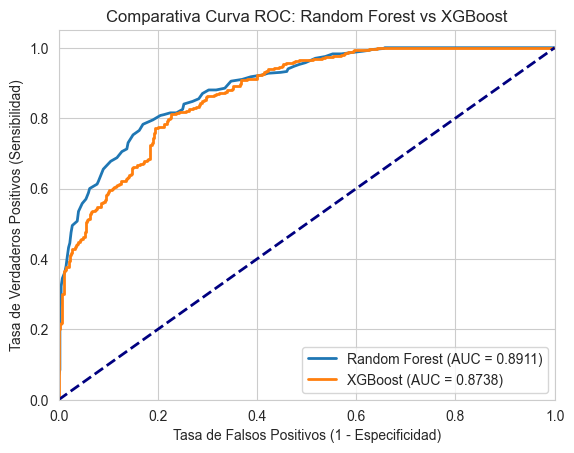

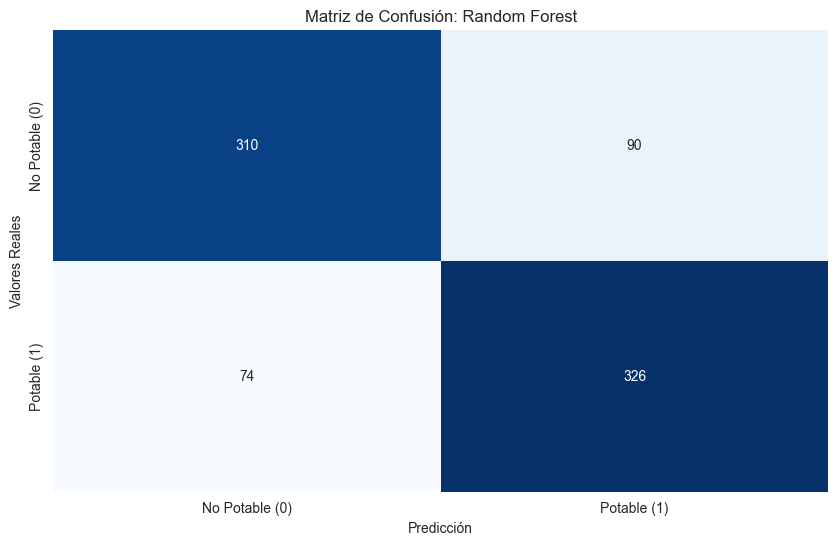

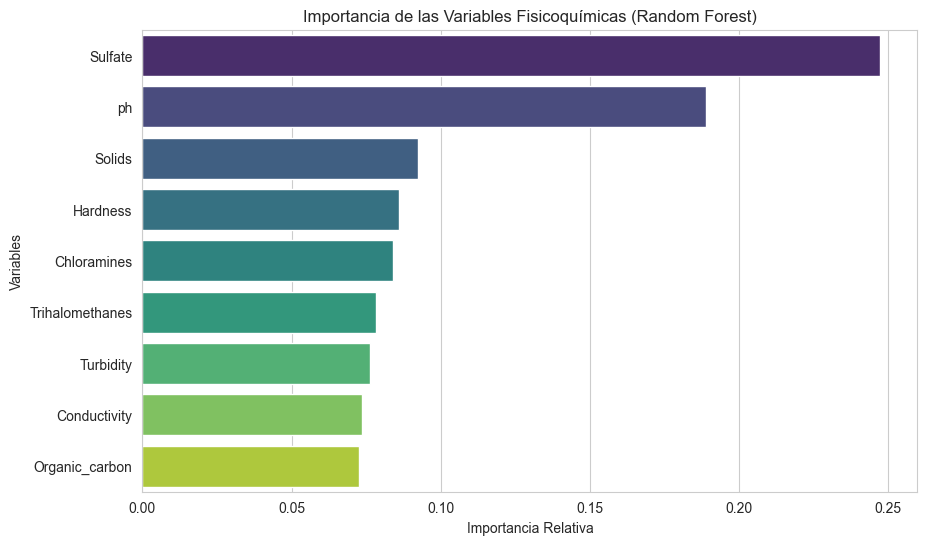

In [8]:
# Gráfica comparativa de curvas ROC
models = [
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model)
]

for name, model in models:
    # Calcular probabilidades
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Plotear la curva ROC
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')

# Linea base aleatoria
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Comparativa Curva ROC: Random Forest vs XGBoost')
plt.legend(loc="lower right")
plt.show()


# Mapa de calor de la matriz de confusión para el mejor modelo
y_pred_rf = rf_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Potable (0)', 'Potable (1)'],
            yticklabels=['No Potable (0)', 'Potable (1)'])
plt.xlabel('Predicción')
plt.ylabel('Valores Reales')
plt.title('Matriz de Confusión: Random Forest')
plt.show()

# Obtener importancia de características
importances = rf_model.feature_importances_

feature_names = X.columns 

# Crear DataFrame para visualizar
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Gráfica de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Importancia de las Variables Fisicoquímicas (Random Forest)')
plt.xlabel('Importancia Relativa')
plt.ylabel('Variables')
plt.show()

El análisis visual confirma la solidez del modelo Random Forest. 
- **La Curva ROC (AUC 0.89)** demuestra su superioridad técnica frente a XGBoost, especialmente en tasas bajas de falsos positivos. 
- **La Matriz de Confusión** revela un modelo equilibrado capaz de detectar correctamente 326 casos de agua potable, aunque se debe prestar atención a los 90 falsos positivos en entornos críticos. 
- **Finalmente, la Importancia de Variables** valida que el modelo basa sus decisiones en indicadores químicos lógicos, priorizando los Sulfatos y el pH como los factores más discriminantes de la potabilidad

In [9]:
# Seleccionar el mejor modelo
best_model = rf_trained

# Guardar el modelo entrenado
joblib.dump(best_model, '../models/water_potability_model.pkl')
print("Modelo final guardado exitosamente en '../models/water_potability_model.pkl'")

Modelo final guardado exitosamente en '../models/water_potability_model.pkl'
